In [1]:
import festim as F
import sympy as sp
import numpy as np

implantation_time = 2000  # s
temperature_ramp = 8  # K/s
storage_time = 50
storage_temp = 300
start_tds = implantation_time + storage_time  # s

exposition_temps = [300, 400, 500]


def tds_model(T_exp):
    my_model = F.Simulation()

    vertices = np.concatenate(
        [
            np.linspace(0, 30e-9, num=100),
            np.linspace(30e-9, 3e-6, num=200),
            np.linspace(3e-6, 5e-6, num=200),
            np.linspace(5e-6, 20e-6, num=200),
        ]
    )

    my_model.mesh = F.MeshFromVertices(vertices)

    tungsten = F.Material(
        id=1,
        D_0=4.1e-07,  # m2/s
        E_D=0.39,  # eV
    )

    my_model.materials = tungsten

    incident_flux = 5e19  # H/m2/s
    reflection_coeff = 0.5
    implanted_flux = incident_flux * (1 - reflection_coeff)
    ion_flux = sp.Piecewise((implanted_flux, F.t <= implantation_time), (0, True))

    source_term = F.ImplantationFlux(
        flux=ion_flux, imp_depth=5e-9, width=2.1e-9, volume=1  # H/m2/s  # m  # m
    )

    my_model.sources = [source_term]

    w_atom_density = 6.3e28  # atom/m3

    trap_1 = F.Trap(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=1e-3 * w_atom_density,
        materials=tungsten,
    )

    trap_2_distrib = sp.Piecewise((1, F.x < 1e-6), (0, True))
    trap_2 = F.Trap(
        k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.2,
        density=4e-4 * w_atom_density * trap_2_distrib,
        materials=tungsten,
    )

    my_model.traps = [trap_1, trap_2]

    my_model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=0, field=0)]

    my_model.T = F.Temperature(
        value=sp.Piecewise(
            (T_exp, F.t <= implantation_time),
            (storage_temp, F.t <= start_tds),
            (storage_temp + temperature_ramp * (F.t - start_tds), True),
        )
    )

    my_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        final_time=implantation_time + storage_time + 50,
        traps_element_type="DG",
    )

    list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.AverageVolume("T", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
    ]

    derived_quantities = F.DerivedQuantities(
        list_of_derived_quantities,
        show_units=True,
        filename=f"{T_exp}_K/derived_quantities.csv",
    )

    txt_exports = [
        F.TXTExport(
            filename=f"{T_exp}_K/retention.txt", field="retention", times=[start_tds]
        ),
        F.TXTExport(filename=f"{T_exp}_K/trap_1.txt", field="1", times=[start_tds]),
        F.TXTExport(filename=f"{T_exp}_K/trap_2.txt", field="2", times=[start_tds]),
    ]

    my_model.exports = [derived_quantities] + txt_exports

    def max_stepsize(t):
        if t > start_tds:
            return 0.5
        elif implantation_time <= t <= start_tds:
            return 5
        else:
            return None

    my_model.dt = F.Stepsize(
        initial_value=0.5,
        stepsize_change_ratio=1.1,
        max_stepsize=max_stepsize,
        dt_min=1e-05,
        milestones=[implantation_time, start_tds],
    )
    # my_model.log_level = 20
    my_model.initialise()
    my_model.run()
    return my_model, derived_quantities

In [2]:
T_to_quantities = {}
for T_exp in exposition_temps:
    model, derived_quantities = tds_model(T_exp)
    T_to_quantities[T_exp] = derived_quantities

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.1e+03 s    Elapsed time so far: 8.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.1e+03 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.1e+03 s    Elapsed time so far: 3.9 s


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


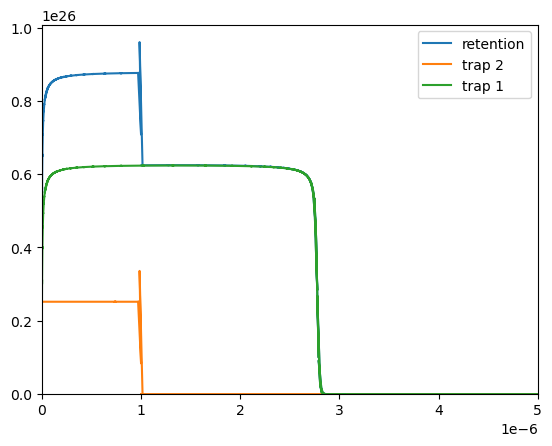

In [3]:
import matplotlib.pyplot as plt

T_exp = exposition_temps[0]
data_retention = np.genfromtxt(f"{T_exp}_K/retention.txt", delimiter=",", skip_header=1)
data_1 = np.genfromtxt(f"{T_exp}_K/trap_1.txt", delimiter=",", skip_header=1)
data_2 = np.genfromtxt(f"{T_exp}_K/trap_2.txt", delimiter=",", skip_header=1)

plt.plot(data_retention[:, 0], data_retention[:, 1], label="retention")
plt.plot(data_2[:, 0], data_2[:, 1], label="trap 2")
plt.plot(data_1[:, 0], data_1[:, 1], label="trap 1")
plt.xlim(0, 5e-6)
plt.ylim(bottom=0)
plt.legend()
plt.show()

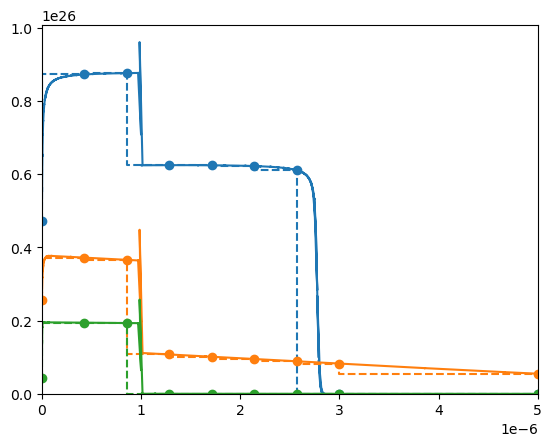

In [7]:
for T_exp in exposition_temps:
    data_retention = np.genfromtxt(
        f"{T_exp}_K/retention.txt", delimiter=",", skip_header=1
    )

    (l,) = plt.plot(data_retention[:, 0], data_retention[:, 1], label=f"{T_exp} K")
    # sample a few points on the retention profile
    sample_points = np.linspace(0, 3e-6, num=8)
    sample_points = np.append(sample_points, 5e-6)
    sample_points_retention = np.interp(
        sample_points, data_retention[:, 0], data_retention[:, 1]
    )

    # plot step plot
    plt.step(
        sample_points,
        sample_points_retention,
        where="pre",
        marker="o",
        color=l.get_color(),
        linestyle="--",
    )
    # dump sample_points and sample_points_retention to file with header
    np.savetxt(
        f"../challenge_B/{T_exp}_K/retention_profile.txt",
        np.column_stack((sample_points, sample_points_retention)),
        header="x (m), retention (H/m3)",
        comments="",
        delimiter=",",
    )
plt.xlim(0, 5e-6)
plt.ylim(bottom=0)
plt.show()

Text(0.5, 0, 'Time (s)')

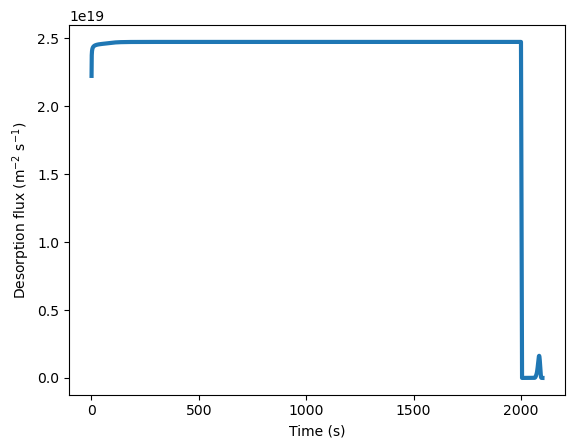

In [8]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
flux_right = derived_quantities.filter(fields="solute", surfaces=2).data

flux_total = -np.array(flux_left) - np.array(flux_right)

plt.plot(t, flux_total, linewidth=3)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

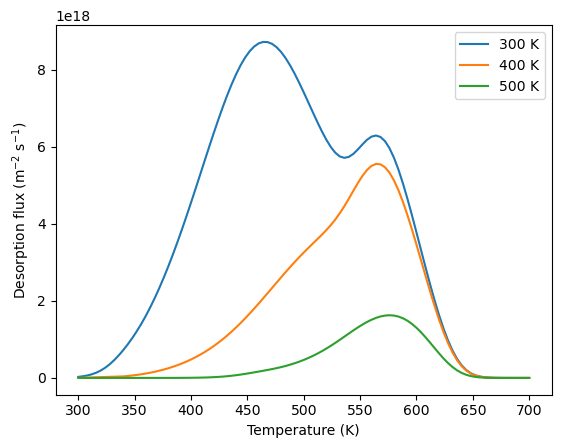

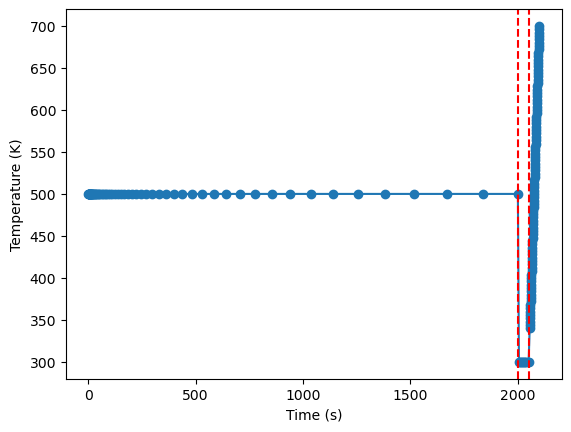

In [9]:
def plot_tds(derived_quantities, contributions=False, **kwargs):
    t = np.array(derived_quantities.t)
    indexes = np.where(t >= start_tds)[0]
    temp = np.array(derived_quantities.filter(fields="T").data)
    flux_left = np.array(derived_quantities.filter(fields="solute", surfaces=1).data)
    flux_right = np.array(derived_quantities.filter(fields="solute", surfaces=2).data)

    flux_total = -flux_left - flux_right
    trap_1 = np.array(derived_quantities.filter(fields="1").data)
    trap_2 = np.array(derived_quantities.filter(fields="2").data)

    temp = temp[indexes]
    flux_total = flux_total[indexes]
    trap_1 = trap_1[indexes]
    trap_2 = trap_2[indexes]
    t = t[indexes]

    contribution_trap_1 = -np.diff(trap_1) / np.diff(t)
    contribution_trap_2 = -np.diff(trap_2) / np.diff(t)

    plt.plot(temp, flux_total, **kwargs)
    if contributions:
        plt.plot(temp[1:], contribution_trap_1, linestyle="--", color="grey")
        plt.fill_between(temp[1:], 0, contribution_trap_1, facecolor="grey", alpha=0.1)
        plt.plot(temp[1:], contribution_trap_2, linestyle="--", color="grey")
        plt.fill_between(temp[1:], 0, contribution_trap_2, facecolor="grey", alpha=0.1)

def save_tds(derived_quantities, filename):
    t = np.array(derived_quantities.t)
    indexes = np.where(t >= start_tds)[0]
    temp = np.array(derived_quantities.filter(fields="T").data)
    flux_left = np.array(derived_quantities.filter(fields="solute", surfaces=1).data)
    flux_right = np.array(derived_quantities.filter(fields="solute", surfaces=2).data)

    flux_total = -flux_left - flux_right
    trap_1 = np.array(derived_quantities.filter(fields="1").data)
    trap_2 = np.array(derived_quantities.filter(fields="2").data)

    temp = temp[indexes]
    flux_total = flux_total[indexes]
    t = t[indexes]

    np.savetxt(
        filename,
        np.column_stack((t, temp, flux_total)),
        header="t (s), T (K), flux (H/m2/s)",
        delimiter=",",
        comments="",
    )

for T_exp in exposition_temps:
    derived_quantities = T_to_quantities[T_exp]
    plot_tds(derived_quantities, label=f"{T_exp} K")
    save_tds(derived_quantities, f"../challenge_B/{T_exp}_K/tds.txt")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")

plt.legend()

plt.figure()
temp = derived_quantities.filter(fields="T").data
plt.plot(t, temp, marker="o")
plt.axvline(x=implantation_time, color="red", linestyle="--")
plt.axvline(x=start_tds, color="red", linestyle="--")
plt.ylabel(r"Temperature (K)")
plt.xlabel(r"Time (s)")
plt.show()